# Synthetic Training Data Generator for FindMyBorough
This notebook generates synthetic training data and visualizes it by score and user situation.

✅ Generated 1400 rows in synthetic_training_data.csv


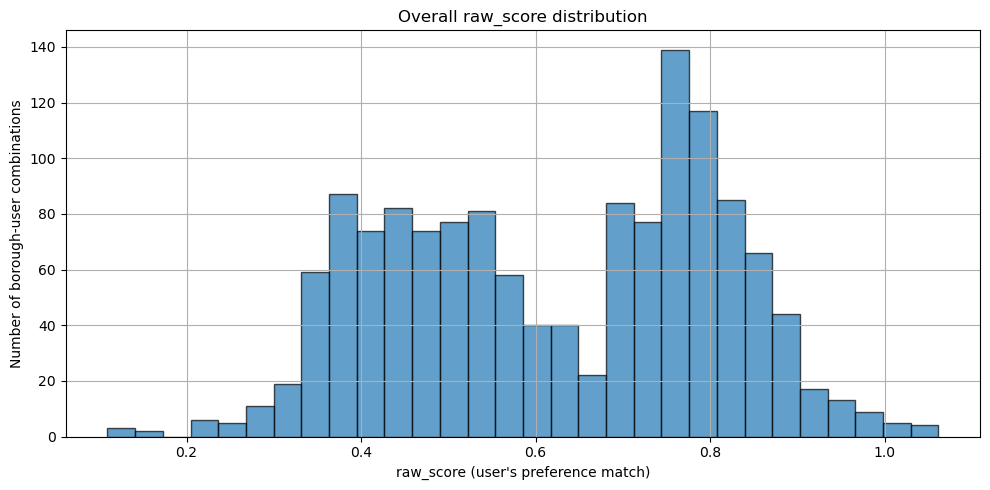


🧮 Binary label counts (score):
score
0    700
1    700
Name: count, dtype: int64


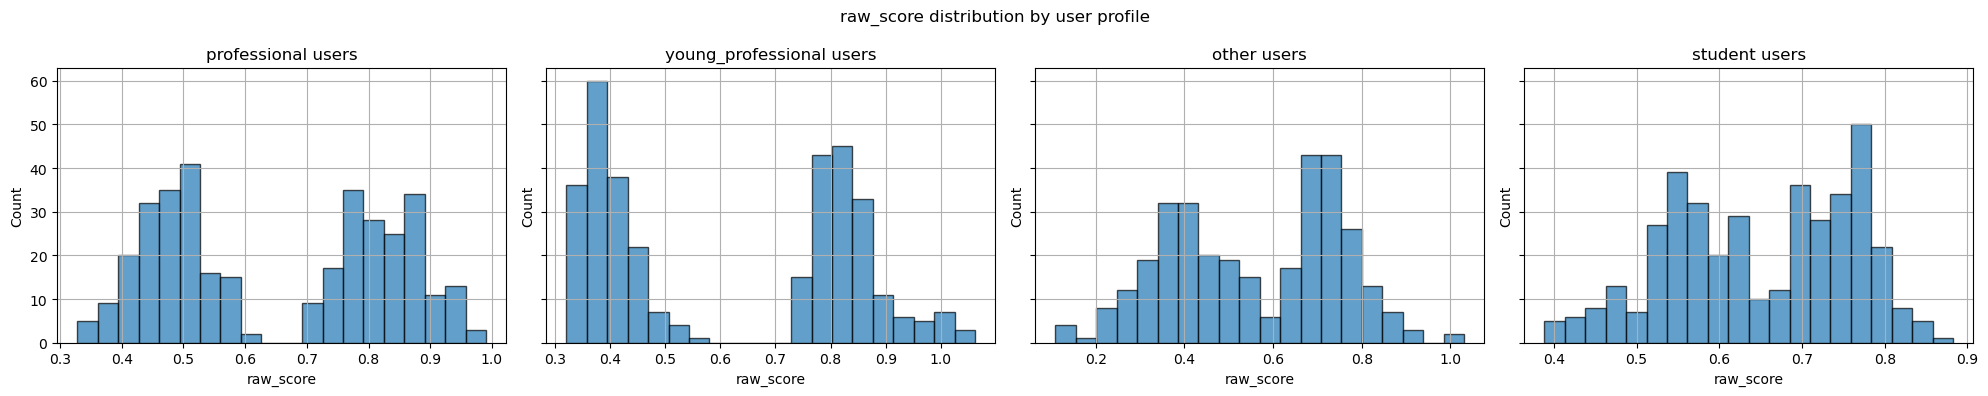


🏙️ Top boroughs per user type (based on positive feedback):

🧍‍♂️ Student users – Top 5 liked boroughs:
1. waltham forest (19 👍)
2. bexley (19 👍)
3. hammersmith and fulham (17 👍)
4. tower hamlets (17 👍)
5. barking and dagenham (17 👍)

🧍‍♂️ Young_professional users – Top 5 liked boroughs:
1. camden (24 👍)
2. city of london (24 👍)
3. hammersmith and fulham (24 👍)
4. tower hamlets (24 👍)
5. wandsworth (24 👍)

🧍‍♂️ Professional users – Top 5 liked boroughs:
1. city of london (25 👍)
2. hammersmith and fulham (25 👍)
3. kensington and chelsea (25 👍)
4. kingston upon thames (25 👍)
5. wandsworth (18 👍)

🧍‍♂️ Other users – Top 5 liked boroughs:
1. city of london (16 👍)
2. hammersmith and fulham (15 👍)
3. wandsworth (14 👍)
4. islington (12 👍)
5. tower hamlets (11 👍)


In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

BASE_PATH = "../data/clean"
CURRENT_SITUATION_OPTIONS = ["student", "young_professional", "professional", "other"]
STAY_DURATION_OPTIONS = ["short_term", "medium_term", "long_term"]

def encode_one_hot(value, options):
    return [1.0 if value == opt else 0.0 for opt in options]

def normalize_weights(weights):
    total = sum(weights)
    return [w / total for w in weights]

def create_user_profile(user_id, situation, duration):
    # Base weights depending on user profile
    if situation == "student":
        base = np.array([0.5, 0.2, 0.3, 0.0])
    elif situation == "young_professional":
        base = np.array([0.2, 0.3, 0.2, 0.3])
    elif situation == "professional":
        base = np.array([0.1, 0.5, 0.1, 0.3])
    else:
        base = np.random.dirichlet(np.ones(4))

    # Add noise to simulate variation
    noise = np.random.normal(0, 0.05, size=4)
    weights = np.clip(base + noise, 0, None)
    weights = normalize_weights(weights)

    return {
        "user_id": user_id,
        "budget_weight": weights[0],
        "safety_weight": weights[1],
        "youth_weight": weights[2],
        "centrality_weight": weights[3],
        "current_situation": situation,
        "stay_duration": duration,
    }

def generate_synthetic_training_data(n_users=100):
    df_boroughs = pd.read_csv(os.path.join(BASE_PATH, "borough_features.csv"))
    df_boroughs["norm_crime"] = df_boroughs["norm_crime"].fillna(df_boroughs["norm_crime"].mean())

    user_profiles = [
        create_user_profile(user_id, random.choice(CURRENT_SITUATION_OPTIONS), random.choice(STAY_DURATION_OPTIONS))
        for user_id in range(1, n_users + 1)
    ]

    training_data = []

    for profile in user_profiles:
        uid = profile["user_id"]
        b_weight = profile["budget_weight"]
        s_weight = profile["safety_weight"]
        y_weight = profile["youth_weight"]
        c_weight = profile["centrality_weight"]
        situation = profile["current_situation"]
        duration = profile["stay_duration"]

        situation_encoding = encode_one_hot(situation, CURRENT_SITUATION_OPTIONS)
        duration_encoding = encode_one_hot(duration, STAY_DURATION_OPTIONS)

        borough_scores = []
        for _, row in df_boroughs.iterrows():
            # Weighted average of borough features
            base_score = (
                b_weight * row["norm_rent"]
                + s_weight * row["norm_crime"]
                + y_weight * row["norm_youth"]
                + c_weight * row["norm_centrality"]
            )

            # Situation and duration-based bonus
            bonus = 0.0
            if situation == "student":
                bonus += (1 - row["norm_rent"]) * 0.2
            elif situation == "professional":
                bonus += row["norm_crime"] * 0.2
            elif situation == "young_professional":
                bonus += (row["norm_youth"] + row["norm_centrality"]) * 0.1

            if duration == "short_term":
                bonus += row["norm_centrality"] * 0.1
            elif duration == "long_term":
                bonus += row["norm_crime"] * 0.1

            raw_score = base_score + bonus

            borough_scores.append(
                (
                    row["borough"],
                    row["norm_rent"],
                    row["norm_crime"],
                    row["norm_youth"],
                    row["norm_centrality"],
                    raw_score,
                )
            )

        raw_scores = [b[5] for b in borough_scores]
        threshold_high = np.percentile(raw_scores, 80)
        threshold_low = np.percentile(raw_scores, 20)

        if threshold_high <= threshold_low:
            threshold_high = max(raw_scores)
            threshold_low = min(raw_scores)

        for borough, rent, crime, youth, centrality, raw_score in borough_scores:
            if raw_score >= threshold_high:
                score = 1
            elif raw_score <= threshold_low:
                score = 0
            else:
                continue

            training_data.append(
                [
                    uid,
                    b_weight,
                    s_weight,
                    y_weight,
                    c_weight,
                    *situation_encoding,
                    *duration_encoding,
                    rent,
                    crime,
                    youth,
                    centrality,
                    borough,
                    raw_score,
                    score,
                ]
            )

    df_synth = pd.DataFrame(
        training_data,
        columns=[
            "user_id",
            "budget_weight",
            "safety_weight",
            "youth_weight",
            "centrality_weight",
            "situation_student",
            "situation_young_professional",
            "situation_professional",
            "situation_other",
            "stay_short_term",
            "stay_medium_term",
            "stay_long_term",
            "norm_rent",
            "norm_crime",
            "norm_youth",
            "norm_centrality",
            "borough",
            "raw_score",
            "score",
        ],
    )

    output_path = os.path.join(BASE_PATH, "synthetic_training_data.csv")
    os.makedirs(BASE_PATH, exist_ok=True)
    df_synth.to_csv(output_path, index=False)
    print("✅ Generated", len(df_synth), "rows in synthetic_training_data.csv")

    # Plot: overall score distribution
    plt.figure(figsize=(10, 5))
    plt.hist(df_synth["raw_score"], bins=30, edgecolor="black", alpha=0.7)
    plt.title("Overall raw_score distribution")
    plt.xlabel("raw_score (user's preference match)")
    plt.ylabel("Number of borough-user combinations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Score label balance
    print("\n🧮 Binary label counts (score):")
    print(df_synth["score"].value_counts())

    # Determine user's situation from one-hot
    df_synth["situation"] = (
        df_synth[
            [
                "situation_student",
                "situation_young_professional",
                "situation_professional",
                "situation_other",
            ]
        ]
        .idxmax(axis=1)
        .str.replace("situation_", "")
    )

    # Plot per-user-type score distribution
    situations = df_synth["situation"].unique()
    n_situations = len(situations)

    fig, axes = plt.subplots(1, n_situations, figsize=(5 * n_situations, 4), sharey=True)
    for i, situation in enumerate(situations):
        ax = axes[i] if n_situations > 1 else axes
        subset = df_synth[df_synth["situation"] == situation]
        ax.hist(subset["raw_score"], bins=20, alpha=0.7, edgecolor="black")
        ax.set_title(f"{situation} users")
        ax.set_xlabel("raw_score")
        ax.set_ylabel("Count")
        ax.grid(True)

    plt.suptitle("raw_score distribution by user profile")
    plt.tight_layout()
    plt.show()

    print("\n🏙️ Top boroughs per user type (based on positive feedback):")
    for situation in CURRENT_SITUATION_OPTIONS:
        subset = df_synth[
            (df_synth["score"] == 1) & (df_synth[f"situation_{situation}"] == 1)
        ]
        top_boroughs = (
            subset["borough"]
            .value_counts()
            .head(5)
            .reset_index()
        )
        top_boroughs.columns = ["borough", "count"]


        print(f"\n🧍‍♂️ {situation.capitalize()} users – Top 5 liked boroughs:")
        for i, row in top_boroughs.iterrows():
            print(f"{i+1}. {row['borough']} ({row['count']})")



generate_synthetic_training_data()
